In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Let's define our model that we need to simulate
from scipy.signal import savgol_filter
from unified_model.unified import UnifiedModel
from unified_model import mechanical_components
from unified_model import electrical_components
from unified_model import CouplingModel
from unified_model import metrics
from unified_model import evaluate
from unified_model.utils.utils import collect_samples
from flux_modeller.model import CurveModel
from unified_model.evaluate import Measurement
from unified_model import parameter_search

import nevergrad as ng
import pandas as pd
import cloudpickle
import numpy as np
import copy

from typing import Tuple, Union, Any, Dict, List
import warnings
warnings.simplefilter('ignore')

with open('../scripts/ABC.config', 'rb') as f:
    ABC_CONFIG = cloudpickle.load(f)

## Helper functions
`A`, `B`, `C` are my original "groundtruth" devices.  
`D` is the pseudo-optimal device with one coil and two magnets.

### Create prototype model components

In [3]:
def _create_model_D_components():
    coil_config = electrical_components.CoilConfiguration(
        c=1,
        n_z=88,
        n_w=20,
        l_ccd_mm=0,
        ohm_per_mm=1079 / 1000 / 1000,
        tube_wall_thickness_mm=2,
        coil_wire_radius_mm=0.143/2,
        coil_center_mm=78,
        inner_tube_radius_mm=5.5
    )
    
    magnet_assembly = mechanical_components.MagnetAssembly(
        m=2,
        l_m_mm=10,
        l_mcd_mm=24,
        dia_magnet_mm=10,
        dia_spacer_mm=10
    )
    
    curve_model = CurveModel.load('../data/flux_curve_model/flux_curve_model_2021_05_11.model')
    z, phi = curve_model.predict_curves(np.array([[coil_config.n_z, coil_config.n_w]]))
    phi = phi.flatten()
    flux_model_interp = electrical_components.FluxModelInterp(
        coil_config=coil_config,
        magnet_assembly=magnet_assembly
    )
    flux_model_interp.fit(z.values, phi)
    
    mech_spring = mechanical_components.MechanicalSpring(
        magnet_assembly=magnet_assembly,
        position=140/1000,
        damping_coefficient=None
    )
    
    return (coil_config,
            magnet_assembly,
            flux_model_interp.flux_model,
            flux_model_interp.dflux_model,
            mech_spring)

def _create_model_O_components():
    coil_config = electrical_components.CoilConfiguration(
        c=1,
        n_z=68,
        n_w=20,
        l_ccd_mm=0,
        ohm_per_mm=1079 / 1000 / 1000,
        tube_wall_thickness_mm=2,
        coil_wire_radius_mm=0.143/2,
        coil_center_mm=72,
        inner_tube_radius_mm=5.5
    )
    
    magnet_assembly = mechanical_components.MagnetAssembly(
        m=2,
        l_m_mm=10,
        l_mcd_mm=17,
        dia_magnet_mm=10,
        dia_spacer_mm=10
    )
    
    curve_model = CurveModel.load('../data/flux_curve_model/flux_curve_model_2021_05_11.model')
    z, phi = curve_model.predict_curves(np.array([[coil_config.n_z, coil_config.n_w]]))
    phi = phi.flatten()
    flux_model_interp = electrical_components.FluxModelInterp(
        coil_config=coil_config,
        magnet_assembly=magnet_assembly
    )
    flux_model_interp.fit(z.values, phi)
    
    mech_spring = mechanical_components.MechanicalSpring(
        magnet_assembly=magnet_assembly,
        position=125/1000,
        damping_coefficient=None
    )
    
    return (coil_config,
            magnet_assembly,
            flux_model_interp.flux_model,
            flux_model_interp.dflux_model,
            mech_spring)

def _create_model_A_B_C_components(which_device):
    coil_config = ABC_CONFIG.coil_configs[which_device]
    magnet_assembly = ABC_CONFIG.magnet_assembly
    flux_model= ABC_CONFIG.flux_models[which_device]
    dflux_model = ABC_CONFIG.dflux_models[which_device]

    # We only define this so the spring position is fixed (gets overridden with parameters later)
    mech_spring = mechanical_components.MechanicalSpring(
        magnet_assembly=magnet_assembly,
        position=110/1000,
        damping_coefficient=None  # Make sure things break if we forget
    )
    
    return (coil_config,
            magnet_assembly,
            flux_model,
            dflux_model,
            mech_spring)


### Loading prototypes and getting ground truth measurements

In [4]:
def _prepare_prototype_model(which_device, path='um_prototype.model/') -> UnifiedModel:
    model_prototype = UnifiedModel.load_from_disk(path)
    model_prototype.mechanical_model.set_damper(None)
    model_prototype.set_coupling_model(None)
        
    # Get and assign components
    if which_device in ['A', 'B', 'C']:
        coil_config, magnet_assembly, flux_model, dflux_model, mech_spring = _create_model_A_B_C_components(which_device)
    elif which_device == 'D':
        coil_config, magnet_assembly, flux_model, dflux_model, mech_spring = _create_model_D_components()
    elif which_device == 'O':
        coil_config, magnet_assembly, flux_model, dflux_model, mech_spring = _create_model_O_components()
    else:
        raise ValueError('`which_device` must be "A", "B", "C", "D" or "O".')
        
    model_prototype.electrical_model.set_coil_configuration(coil_config)
    model_prototype.electrical_model.set_flux_model(flux_model, dflux_model)
    model_prototype.mechanical_model.set_magnet_assembly(magnet_assembly)
    model_prototype.mechanical_model.set_mechanical_spring(mech_spring)

    return model_prototype

def _get_measurements(which_device, model_prototype):
    # Prepare data
    if which_device == 'O':
        samples_list = collect_samples(base_path='../data/2021-06-11/E/',
                                       acc_pattern='*acc*.csv',
                                       adc_pattern='*adc*.csv',
                                       video_label_pattern='*labels*.csv')
    elif which_device == 'D':
        samples_list = collect_samples(base_path='../data/2021-03-05/D/',
                                       acc_pattern='*acc*.csv',
                                       adc_pattern='*adc*.csv',
                                       video_label_pattern='*labels*.csv')
    elif which_device in ['A', 'B', 'C']:
        samples_list = collect_samples(base_path='../data/2019-05-23/',
                                       acc_pattern=f'{which_device}/*acc*.csv',
                                       adc_pattern=f'{which_device}/*adc*.csv',
                                       video_label_pattern=f'{which_device}/*labels*.csv')
    else:
        raise ValueError('Samples for device not registered.')

    measurements = [evaluate.Measurement(s, model_prototype) for s in samples_list]
    return measurements

def get_prototype_and_measurements(
    which_device: UnifiedModel,
    path: str ='um_prototype.model/'
) -> Tuple[UnifiedModel, List[Measurement]]:
    
    model_prototype = _prepare_prototype_model(which_device, path)
    measurements = _get_measurements(which_device, model_prototype)
    
    return model_prototype, measurements

def make_unified_model_from_params(
    model_prototype,
    damper_cdc,
    coupling_constant,
    mech_spring_constant
) -> UnifiedModel:
        model = copy.deepcopy(model_prototype)
        
        damper = mechanical_components.MassProportionalDamper(
            damper_cdc,
            model.mechanical_model.magnet_assembly
        )
        
        coupling_model = CouplingModel().set_coupling_constant(coupling_constant)
        
        mech_spring = mechanical_components.MechanicalSpring(
            magnet_assembly=model.mechanical_model.magnet_assembly,
            position=model.mechanical_model.mechanical_spring.position,
            damping_coefficient=mech_spring_constant
        )
        
        model.mechanical_model.set_damper(damper)
        model.set_coupling_model(coupling_model)
        model.mechanical_model.set_mechanical_spring(mech_spring)
        
        return model
    

def make_unified_model_from_path(
    model_prototype,
    param_path
) -> UnifiedModel:

    with open(param_path, 'rb') as f:
        params = cloudpickle.load(f)
        
    return make_unified_model_from_params(
        model_prototype=model_prototype,
        damper_cdc=params['damper_cdc'],
        coupling_constant=params['coupling_constant'],
        mech_spring_constant=params['mech_spring_constant']
    )

# Method 1: Mean of Votes

$$p_{i,d} := \min_{p}~\text{Cost}(\text{input}_i, \text{device}_d, p),$$ 
for $\text{for}~i \in \{\text{inputs}\},~d \in \{\text{devices}\}$ and $p$ being the set of parameters.

We then define our optimal set of parameters $P^{*}$ as the mean of each parameter set $p_i$ that minimizes the cost of each corresponding input for each device. 

$$P^{*} := \sum_{i,d}^{N, D} \frac{p_{i, d}}{N \cdot D}$$

In other words, we choose the best parameter set for each measurement of each device, and then take the weighted mean of each of those best parameter sets to get our final parameter set.

### Execute

In [6]:
from ray import tune
from pympler import muppy, summary

instruments = {
    'damping_coefficient': ng.p.Scalar(lower=0, upper=10),
    'coupling_constant': ng.p.Scalar(lower=0, upper=10),
    'mech_spring_constant': ng.p.Scalar(lower=0, upper=10)
}

for dev in ['A', 'B', 'C', 'D']:
    print(f'🏃 :: {dev}')
    model_prototype, measurements = get_prototype_and_measurements(dev)
    candidate_params = parameter_search.mean_of_votes(
        model_prototype=model_prototype,
        measurements=measurements,
        instruments=instruments,
        budget=5
    )

    # Write to disk
    with open(f'candidate_params_m1_{dev}_debug.params', 'wb') as f:
        cloudpickle.dump(candidate_params, f)

🏃 :: A


2021-06-24 11:05:13,601	INFO services.py:1274 -- View the Ray dashboard at http://127.0.0.1:8265


Output()

🏃 :: B


2021-06-24 11:05:23,359	INFO services.py:1274 -- View the Ray dashboard at http://127.0.0.1:8265


Output()

🏃 :: C


2021-06-24 11:05:32,199	INFO services.py:1274 -- View the Ray dashboard at http://127.0.0.1:8265


Output()

🏃 :: D


2021-06-24 11:05:41,804	INFO services.py:1274 -- View the Ray dashboard at http://127.0.0.1:8265


Output()

In [18]:
candidate_params

{'damping_coefficient': [3.0428442402890976,
  4.355751848776347,
  3.2080283533632024,
  2.8164774460200404,
  2.413801731653926,
  1.784886640958928,
  2.271416891416524],
 'coupling_constant': [4.035178313230325,
  3.2378127057312667,
  2.0962545740117595,
  3.8811551298012823,
  4.084490175070626,
  4.141336801872049,
  4.376203672219784],
 'mech_spring_constant': [3.8428762943393955,
  4.3509419691560955,
  0.9463140334836003,
  3.47616056024876,
  6.251618864352519,
  6.767295148176688,
  2.734883774539403],
 'loss': [0.003477088507613786,
  0.0032383060353869232,
  0.0022480569432710845,
  0.0025725967438591448,
  0.004418251117786322,
  0.0024293305466322208,
  0.0026582911303499606]}

# Method 2: Mean of Scores

$$P^{*} := \min_{p} \sum_{i, d}^{N, D} C(\text{input}_i, \text{device}_d, p)$$

In other words, simulate all the measurements for the same parameter set and take the parameter set that produces the lowest mean cost / error across all devices and corresponding inputs.

## Execute

In [8]:
models_and_measurements = [
    get_prototype_and_measurements('A'),
    get_prototype_and_measurements('B'),
    get_prototype_and_measurements('C'),
    get_prototype_and_measurements('D')
]

instruments = {
    'damping_coefficient': ng.p.Scalar(init=5, lower=0, upper=10),
    'coupling_constant': ng.p.Scalar(init=5, lower=5, upper=10),
    'mech_spring_constant': ng.p.Scalar(init=5, lower=0, upper=10)
}

candidate_params = parameter_search.mean_of_scores(
    models_and_measurements,
    instruments,
    budget=10
)

with open('candidate_params_m2_debug.params', 'wb') as f:
    cloudpickle.dump(candidate_params, f)

2021-06-24 14:38:21,243	INFO services.py:1274 -- View the Ray dashboard at http://127.0.0.1:8265


Output()

# Test our "best" parameter values from the two parameter search methods

### Helper functions

In [9]:
def run(unified_model, measurement):
    unified_model = copy.deepcopy(unified_model)
    unified_model.mechanical_model.set_input(measurement.input_)
        
    # Solve...
    y0 = [0.0, 0.0, 0.0325, 0.0, 0.0]
    unified_model.solve(
        t_start=0,
        t_end=8,
        y0=y0,
        t_eval=np.linspace(0, 8, 1000),
        t_max_step=1e-3
    )
        
    # ... and Score ...
    results, evaluators = unified_model.score_measurement(
        measurement=measurement,
        mech_pred_expr='x3-x1',
        mech_metrics_dict={'y_diff_dtw_distance': metrics.dtw_euclid_distance,
                           'y_diff_dtw_norm': metrics.dtw_euclid_norm_by_length},
        elec_pred_expr='g(t, x5)',
        elec_metrics_dict={'rms_perc_diff': metrics.root_mean_square_percentage_diff,
                           'emf_dtw_distance': metrics.dtw_euclid_distance,
                           'emf_dtw_norm': metrics.dtw_euclid_norm_by_length},
    )
   
    # ... and Parse.
    y_curves = {
        'y_time': evaluators['mech'].time_,
        'y_target': evaluators['mech'].y_target_,
        'y_predict': evaluators['mech'].y_predict_
    }
    
    emf_curves = {
        'emf_time': evaluators['elec'].time_,
        'emf_target': evaluators['elec'].emf_target_,
        'emf_predict': evaluators['elec'].emf_predict_
    }
    
    return results, y_curves, emf_curves


## Method 1: Mean of Votes

In [13]:
from tqdm.notebook import tqdm
from typing import Dict, List

def meta_run(params: Dict[str, float], devices=['A', 'B', 'C', 'D']):
    """Run simulations for a single set of parameters and a number of devices"""
    results = {
        'scores': [],
        'y_curves': [],
        'emf_curves': [],
        'device': [],
        'measurement': [],
        'measurement_id': []
    }
    print(f'🏃: {devices}')
    for dev in tqdm(devices):
        model_prototype, measurements = get_prototype_and_measurements(dev)
        model = make_unified_model_from_params(model_prototype, **params)

        for i, m in tqdm(list(enumerate(measurements))):
            score, y_curves, emf_curves = run(model, m)
            results['scores'].append(score)
            results['y_curves'].append(y_curves)
            results['emf_curves'].append(emf_curves)
            results['device'].append(dev)
            results['measurement'].append(m)
            results['measurement_id'].append(i)
    return results

### Load our candidate parameters from disk

In [15]:
candidate_params = {}
for dev in ['A', 'B', 'C', 'D']:
    with open(f'candidate_params_m1_{dev}.params', 'rb') as f:
        from_disk = cloudpickle.load(f)
        if candidate_params:
            for k,v in from_disk.items():
                candidate_params[k] = candidate_params[k] + v
        else:
            candidate_params = from_disk

df = pd.DataFrame(candidate_params)
print(df.mean())
temp = df.mean().values[:3]  # Get the weighted mean

params_m1 = {
    'damper_cdc': temp[0],
    'coupling_constant': temp[1],
    'mech_spring_constant': temp[2]
}

print('===')
print('🧮: ', params_m1)
print('===')

damper_cdc              1.221201
coupling_constant       5.911221
mech_spring_constant    5.319698
loss                    0.036592
dtype: float64
===
🧮:  {'damper_cdc': 1.2212013683646077, 'coupling_constant': 5.9112209459475045, 'mech_spring_constant': 5.319698383830252}
===


### Simulate and Score

In [16]:
results_m1 = meta_run(params_m1, devices=['A', 'B', 'C', 'D', 'O'])

🏃: ['A', 'B', 'C', 'D', 'O']


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

## Method 2: Mean of scores

In [17]:
# Load params from disk
with open('candidate_params_m2.params', 'rb') as f:
    params_m2 = cloudpickle.load(f)
params_m2

{'damper_cdc': 0.45191310977446686,
 'coupling_constant': 6.829572548864586,
 'mech_spring_constant': 7.905269161296499}

In [19]:
results_m2 = meta_run(params_m2, devices=['A', 'B', 'C', 'D', 'O'])

🏃: ['A', 'B', 'C', 'D', 'O']


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

# Plot Comparisons

In [20]:
def parse_results(results: dict, which_component: str) -> dict:
    df_list = []
    scores_list = []
    
    if which_component == 'mech':
        for y_curves, measurement_id, device, score in zip(results['y_curves'], results['measurement_id'], results['device'], results['scores']):
            df = pd.DataFrame(y_curves)
            df['input_id'] = measurement_id
            df['device'] = device
            df_list.append(df)
    elif which_component == 'elec':
        for emf_curves, measurement_id, device in zip(results['emf_curves'], results['measurement_id'], results['device']):
            df = pd.DataFrame(emf_curves)
            df['input_id'] = measurement_id
            df['device'] = device
            df_list.append(df)
    
    df_scores = pd.DataFrame(results['scores'])
    df_scores['device'] = results['device']
    df_scores['input_id'] = results['measurement_id']

    df_results = pd.concat(df_list).reset_index(drop=True)
    parsed = {
        'curves': df_results,
        'scores': df_scores
    }
    return parsed

## Method 1 vs Method 2 comparison
### Mech

In [21]:
from plotnine import *

In [22]:
df_m1_mech = parse_results(results_m1, 'mech')['curves']
df_m2_mech = parse_results(results_m2, 'mech')['curves']

df_m1_mech_melt = df_m1_mech.melt(id_vars=['input_id', 'device', 'y_time'])
df_m2_mech_melt = df_m2_mech.melt(id_vars=['input_id', 'device', 'y_time'])

var_cat = pd.Categorical(df_m1_mech_melt['variable'].values, categories=['y_target', 'y_predict'], ordered=True)
df_m1_mech_melt['variable'] = var_cat

var_cat = pd.Categorical(df_m2_mech_melt['variable'].values, categories=['y_target', 'y_predict'], ordered=True)
df_m2_mech_melt['variable'] = var_cat

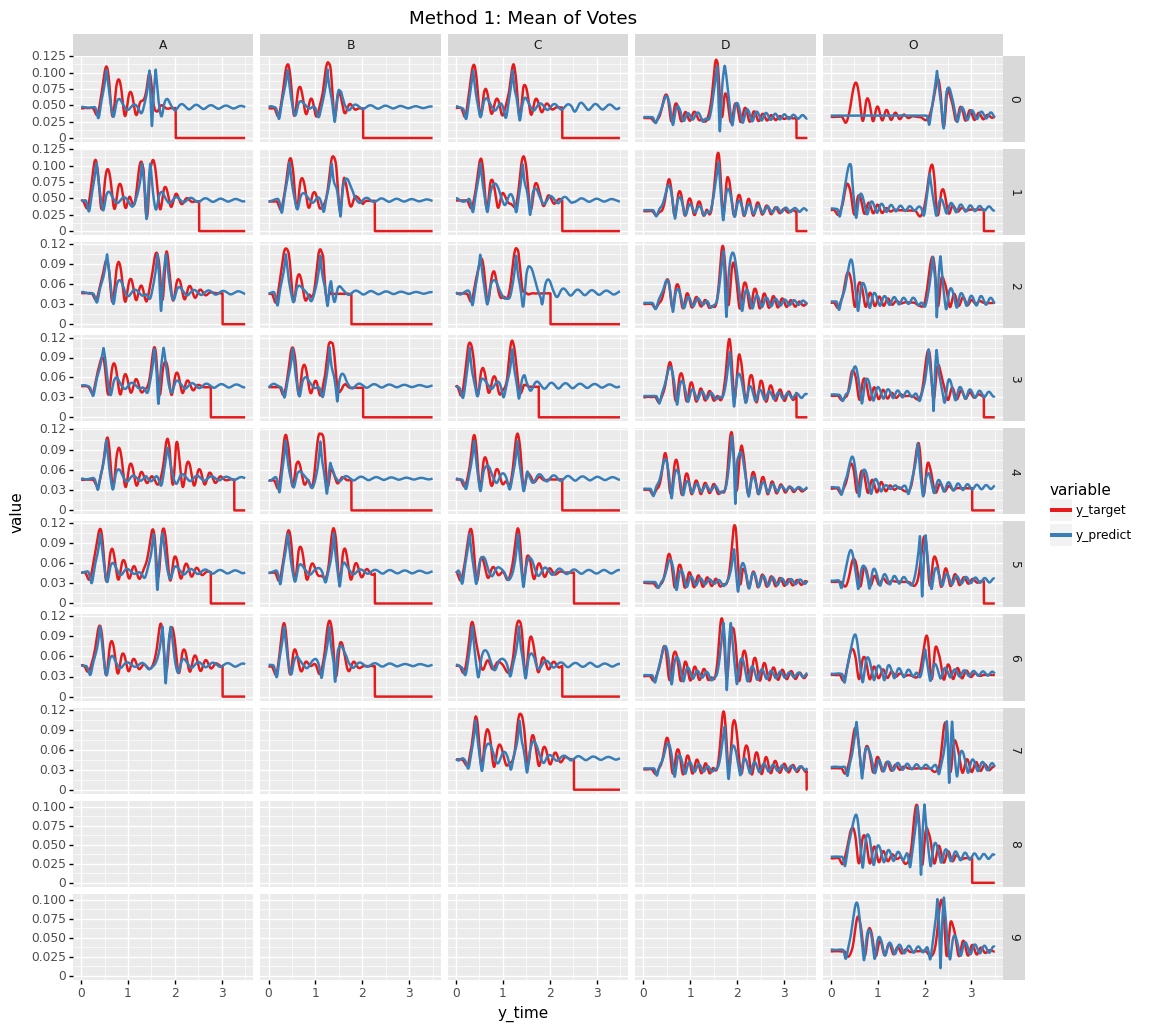

<ggplot: (-9223363247238184255)>

In [28]:
%matplotlib inline
p = ggplot(aes(x='y_time', y='value', color='variable'), df_m1_mech_melt)
p \
+ geom_line(size=1) \
+ facet_grid('input_id ~ device', scales='free_y') \
+ xlim(0, 3.5) \
+ scale_color_brewer('qual', 6) \
+ theme(figure_size=(12, 12)) \
+ ggtitle("Method 1: Mean of Votes")

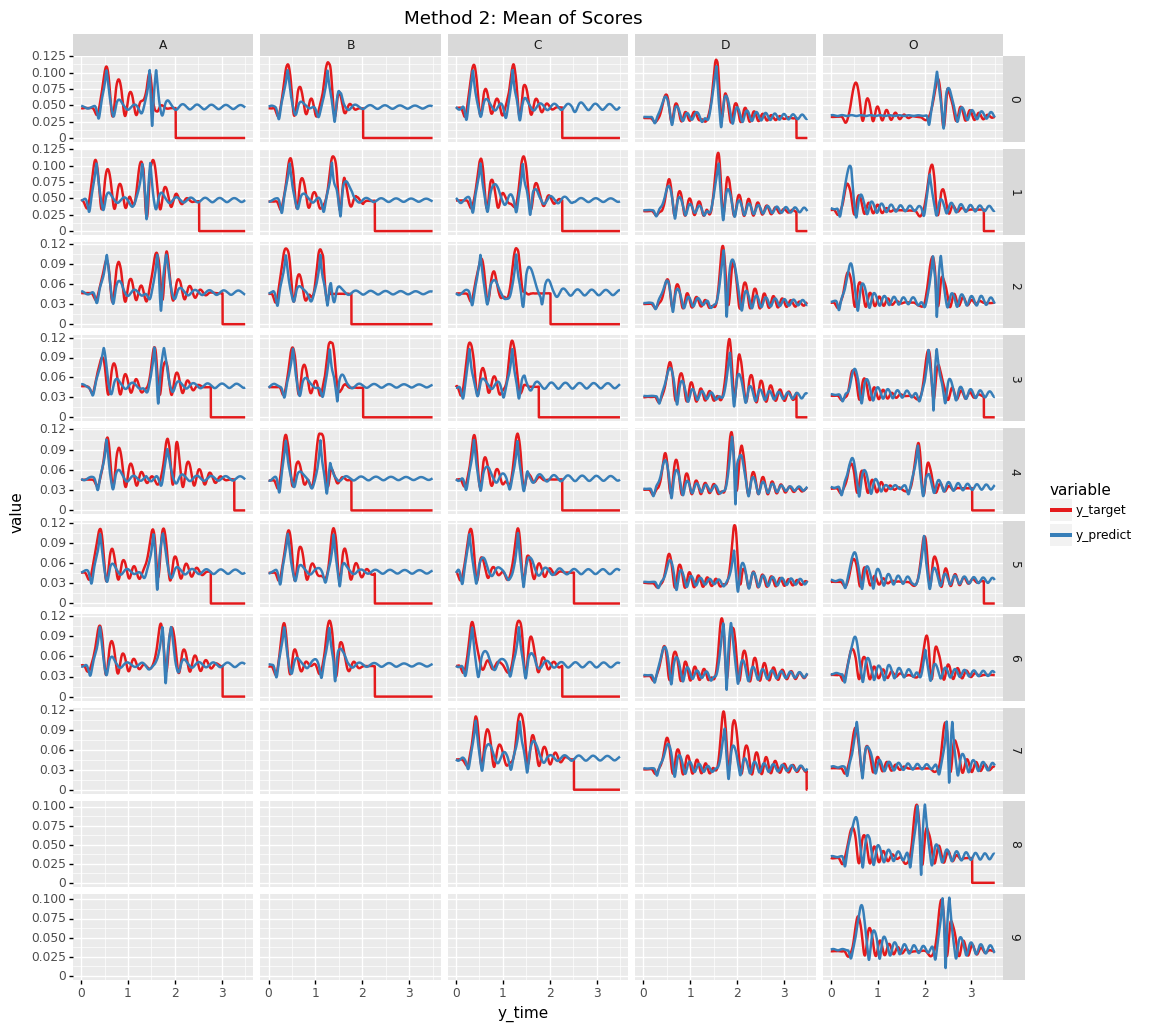

<ggplot: (8789615922159)>

In [29]:
%matplotlib inline
p = ggplot(aes(x='y_time', y='value', color='variable'), df_m2_mech_melt)
p + geom_line(size=1) + facet_grid('input_id ~ device', scales='free_y') + xlim(0, 3.5) + theme(figure_size=(12, 12)) + scale_color_brewer('qual', 6) + ggtitle('Method 2: Mean of Scores')

Can you subjectively tell which looks better? I think Method 1 _looks_ better. Let's compare the scores and see what the metrics say:

In [42]:
from typing import List

m1_scores = parse_results(results_m1, which_component='mech')['scores']
m2_scores = parse_results(results_m2, which_component='mech')['scores']

def drop_bad(
    df: pd.DataFrame,
    devices: List[str],
    amount_to_drop: List[int]
) -> pd.DataFrame:
    """Drop the worst performers."""
    indexes_to_drop = []
    for dev, num_to_drop in zip(devices, amount_to_drop):
        to_drop = df.query(f'device == "{dev}"').sort_values(by='emf_dtw_norm', ascending=False).index[0:num_to_drop].tolist()
        indexes_to_drop = indexes_to_drop + to_drop
    df_filtered = df.drop(indexes_to_drop)
    return df_filtered

m1_scores_filtered = drop_bad(m1_scores, ['A', 'B', 'C', 'D', 'O'], [2, 2, 3, 3, 5])
m2_scores_filtered = drop_bad(m2_scores, ['A', 'B', 'C', 'D', 'O'], [2, 2, 3, 3, 5])

print('🟧 1 🟧')
print('--------------------------------')
print(m1_scores.mean())
print('--------------------------------')
print()
print('🟧 2 🟧')
print('--------------------------------')
print(m2_scores.mean())
print('--------------------------------')

print('=================================')
print('')
print('🟩 1 (filtered) 🟩')
print('--------------------------------')
print(m1_scores_filtered.mean())
print('--------------------------------')
print()
print('🟩 2 (filtered) 🟩')
print('--------------------------------')
print(m2_scores_filtered.mean())
print('--------------------------------')

🟧 1 🟧
--------------------------------
y_diff_dtw_distance      9.451004
y_diff_dtw_norm          0.002748
rms_perc_diff           -1.286283
emf_dtw_distance       115.630659
emf_dtw_norm             0.043106
input_id                 3.575000
dtype: float64
--------------------------------

🟧 2 🟧
--------------------------------
y_diff_dtw_distance      9.496789
y_diff_dtw_norm          0.002779
rms_perc_diff           -5.560246
emf_dtw_distance       115.645733
emf_dtw_norm             0.043262
input_id                 3.575000
dtype: float64
--------------------------------

🟩 1 (filtered) 🟩
--------------------------------
y_diff_dtw_distance      8.100928
y_diff_dtw_norm          0.002446
rms_perc_diff            2.073436
emf_dtw_distance       100.029532
emf_dtw_norm             0.038800
input_id                 3.400000
dtype: float64
--------------------------------

🟩 2 (filtered) 🟩
--------------------------------
y_diff_dtw_distance     8.233661
y_diff_dtw_norm         0.0025

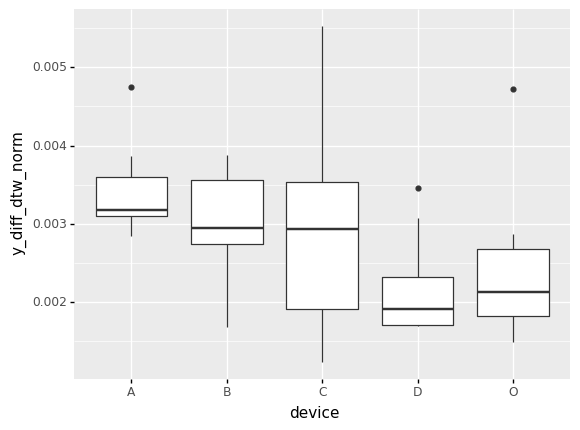

<ggplot: (-9223363247239715391)>

In [46]:
p = ggplot(aes(x='device', y='y_diff_dtw_norm'), m1_scores)
p + geom_boxplot()

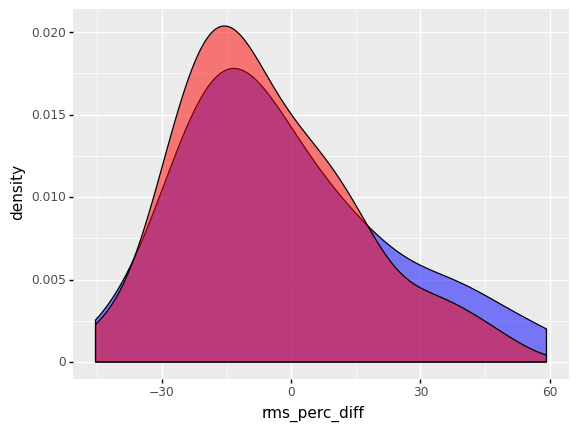

<ggplot: (-9223363247239578869)>

In [73]:
p = ggplot()
p + geom_density(aes(x='rms_perc_diff'), data=m1_scores, fill='blue', alpha=0.5) \
 + geom_density(aes(x='rms_perc_diff'), data=m2_scores, fill='red', alpha=0.5)

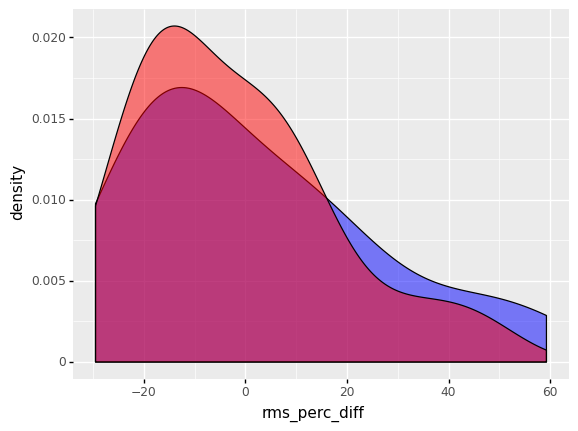

<ggplot: (8789606361373)>

In [72]:
p = ggplot()
p + geom_density(aes(x='rms_perc_diff'), data=m1_scores_filtered, fill='blue', alpha=0.5) \
 + geom_density(aes(x='rms_perc_diff'), data=m2_scores_filtered, fill='red', alpha=0.5)

### Elec

In [31]:
df_m1_elec = parse_results(results_m1, 'elec')['curves']
df_m2_elec = parse_results(results_m2, 'elec')['curves']

df_m1_elec_melt = df_m1_elec.melt(id_vars=['input_id', 'device', 'emf_time'])
df_m2_elec_melt = df_m2_elec.melt(id_vars=['input_id', 'device', 'emf_time'])

var_cat = pd.Categorical(df_m1_elec_melt['variable'].values, categories=['emf_target', 'emf_predict'], ordered=True)
df_m1_elec_melt['variable'] = var_cat

var_cat = pd.Categorical(df_m2_elec_melt['variable'].values, categories=['emf_target', 'emf_predict'], ordered=True)
df_m2_elec_melt['variable'] = var_cat

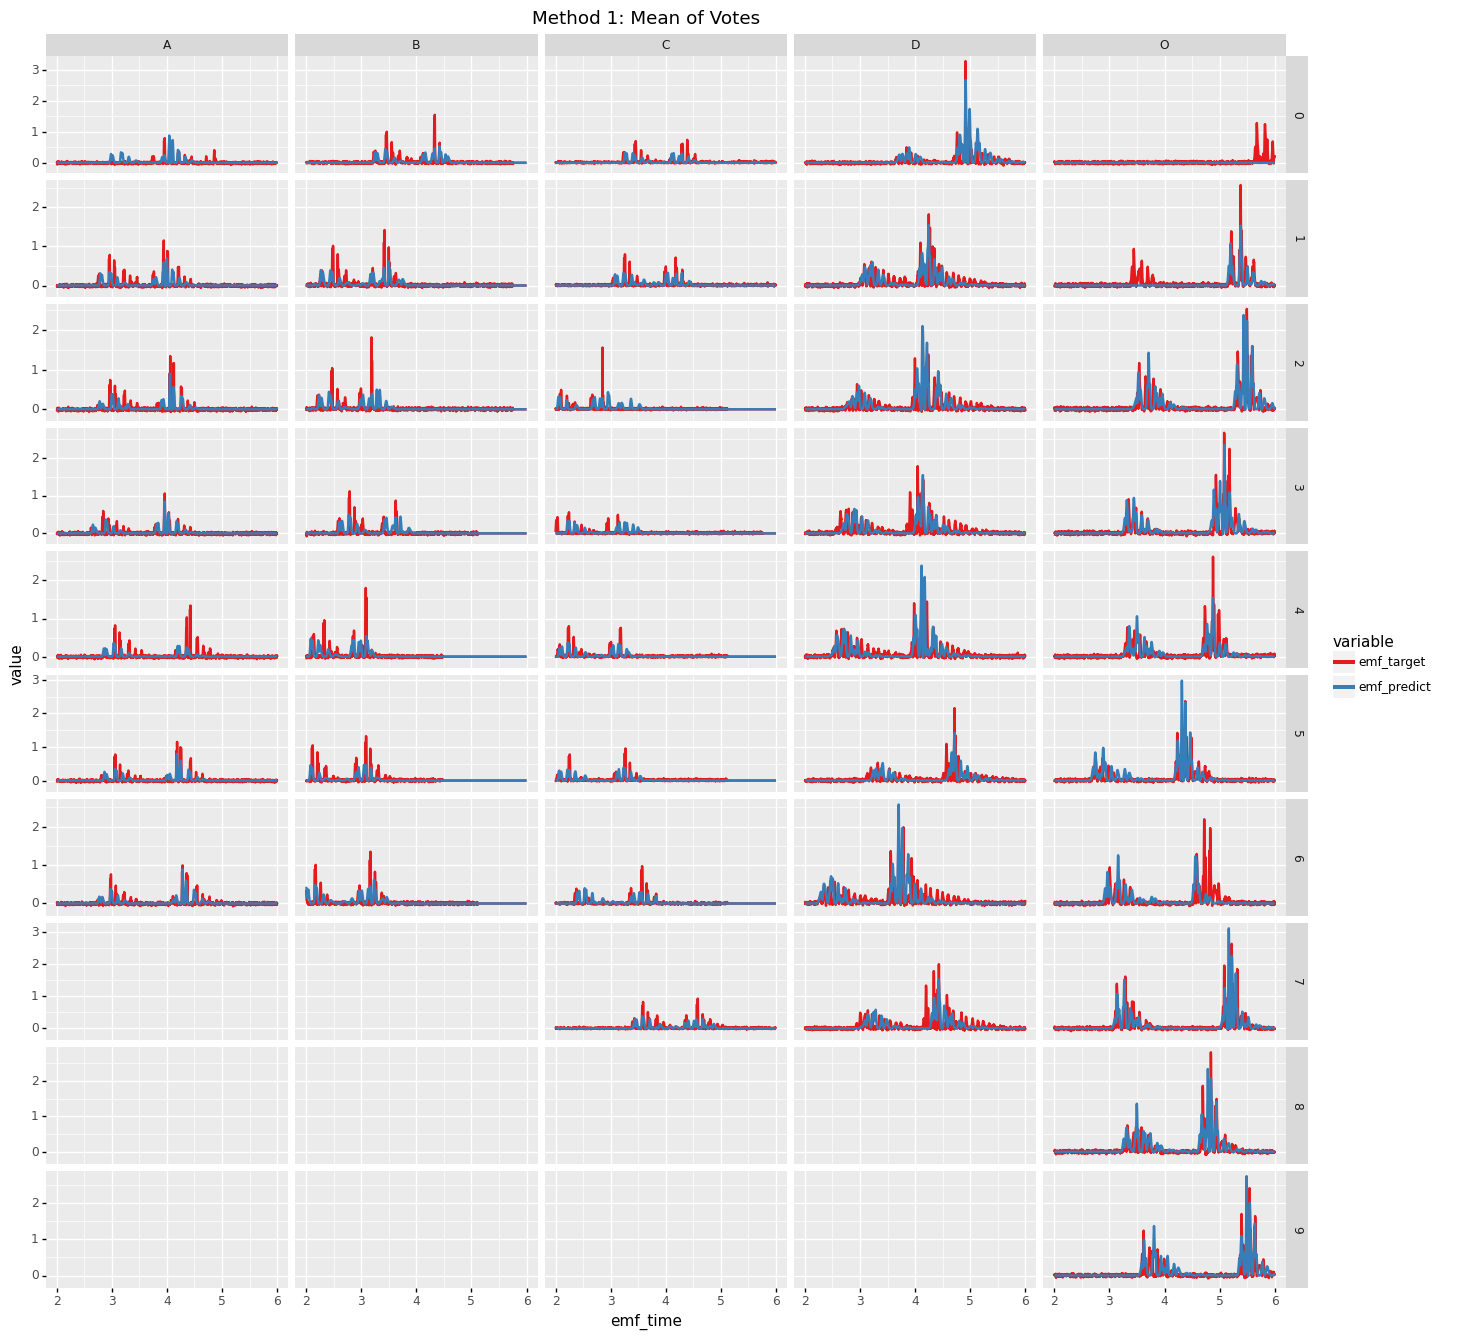

<ggplot: (-9223363247246616646)>

In [32]:
%matplotlib inline
p = ggplot(aes(x='emf_time', y='value', color='variable'), df_m1_elec_melt)
p \
+ geom_line(size=1) \
+ facet_grid('input_id ~ device', scales='free_y') \
+ scale_color_brewer('qual', 6) \
+ xlim(2, 6) \
+ theme(figure_size=(16, 16)) \
+ ggtitle("Method 1: Mean of Votes")

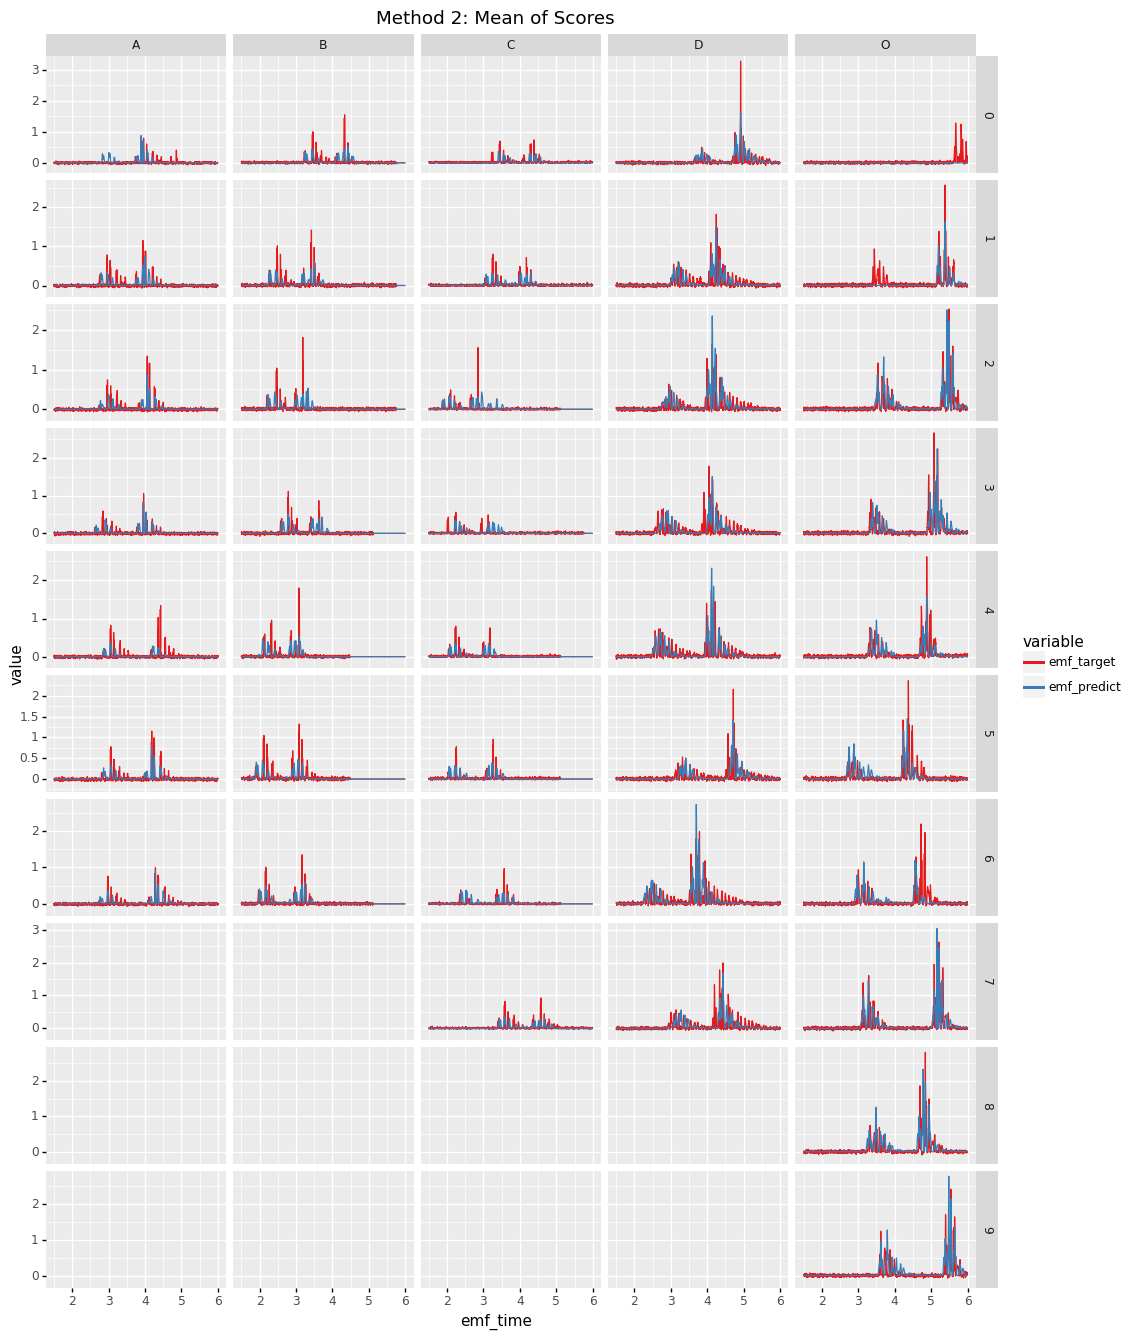

<ggplot: (8789608104161)>

In [33]:
%matplotlib inline
p = ggplot(aes(x='emf_time', y='value', color='variable'), df_m2_elec_melt)
p \
+ geom_line(size=0.5) \
+ facet_grid('input_id ~ device', scales='free_y') \
+ scale_color_brewer('qual', 6) \
+ xlim(1.5, 6) \
+ theme(figure_size=(12, 16)) \
+ ggtitle("Method 2: Mean of Scores")